## Importing Dependencies

In [2]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading Datasets

In [4]:
train_dir = 'imgdata_v2/split_dataset/train_aug/'
test_dir = 'imgdata_v2/split_dataset/test/'
val_dir = 'imgdata_v2/split_dataset/val/'

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(256, 256))
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(256, 256))

Found 7051 files belonging to 2 classes.
Found 415 files belonging to 2 classes.


## Scaling Dataset

In [6]:
train_dataset.as_numpy_iterator().next()[0][0].max()

255.0

In [7]:
train_data = train_dataset.map(lambda x, y: (x/255, y))

In [8]:
train_data.as_numpy_iterator().next()[0][0].max()

1.0

In [9]:
val_data = val_dataset.map(lambda x, y: (x/255, y))

## CNN Model Architecture

In [10]:
import tensorflow as tf
from keras import Sequential,Model,models
from keras.layers import Dense,Dropout,Flatten,BatchNormalization, Conv2D, MaxPooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2 , preprocess_input

In [11]:
inception_arch=InceptionResNetV2(input_shape=[256, 256] + [3],weights="imagenet",include_top=False)

In [12]:
for layer in inception_arch.layers:
    layer.trainaable = False

In [13]:
model = Sequential()
model.add(inception_arch)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

In [14]:
model.compile(optimizer="adam",loss="mse",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dense (Dense)               (None, 256)               14156032  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 68,493,025
Trainable params: 68,432,481
Non-trainable params: 60,544
_________________________________________________________________


In [34]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
logdir = 'LogDir'

try:
    os.mkdir('saved_models')
    os.mkdir('CSV_logs')
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
log_csv = CSVLogger('CSV_logs/my_logs.csv', separator=', ', append=False)

callbacks_list = [tfb_callback, early_stop, log_csv]

In [16]:
model_fit = model.fit(train_data, 
                       epochs=5, 
                       shuffle=True, 
                       validation_data=val_data,
                       callbacks=callbacks_list)

Epoch 1/5
221/221 [==============================] - 130s 442ms/step - loss: 14.2014 - accuracy: 0.8741 - val_loss: 0.0495 - val_accuracy: 0.9518
Epoch 2/5
221/221 [==============================] - 97s 437ms/step - loss: 0.0508 - accuracy: 0.9556 - val_loss: 0.1529 - val_accuracy: 0.8892
Epoch 3/5
221/221 [==============================] - 95s 428ms/step - loss: 0.0312 - accuracy: 0.9766 - val_loss: 0.0652 - val_accuracy: 0.9349
Epoch 4/5
221/221 [==============================] - 94s 426ms/step - loss: 0.0273 - accuracy: 0.9843 - val_loss: 0.0443 - val_accuracy: 0.9542
Epoch 5/5
221/221 [==============================] - 96s 435ms/step - loss: 0.0225 - accuracy: 0.9887 - val_loss: 0.0507 - val_accuracy: 0.9518


## Model Performance 

Text(0.5, 0.98, 'InceptionResNetV2 Model Performance Curves')

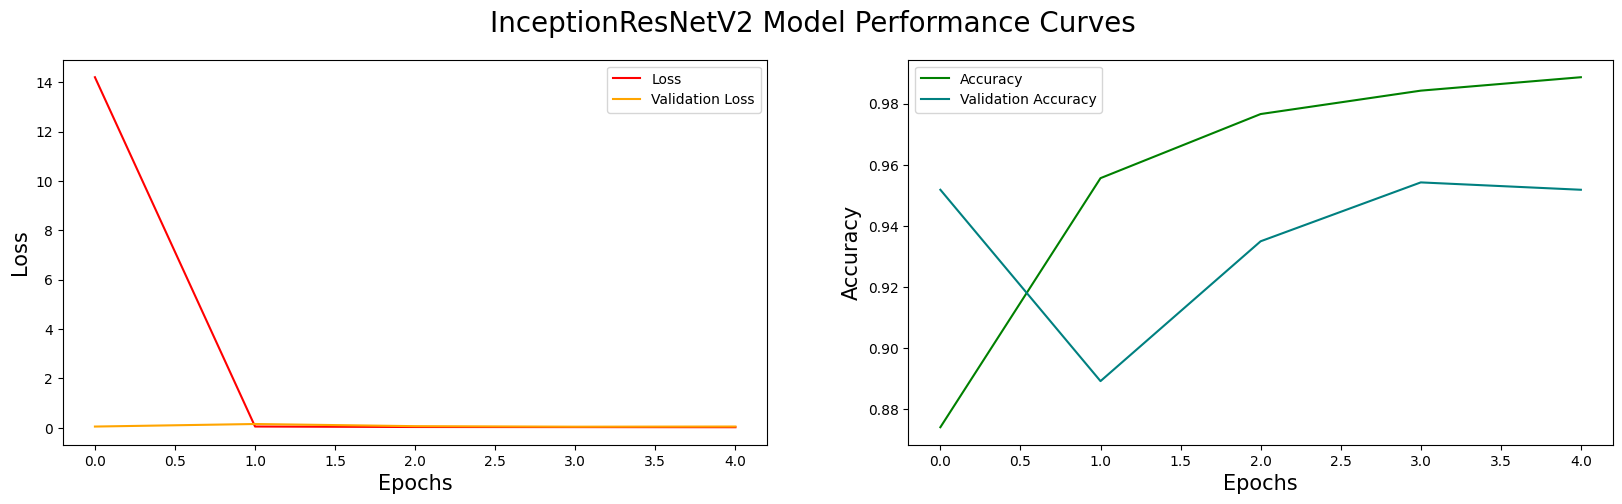

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epochs', fontsize=15)
axs[0].set_ylabel('Loss', fontsize=15)


axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Epochs', fontsize=15)
axs[1].set_ylabel('Accuracy', fontsize=15)

fig.suptitle('InceptionResNetV2 Model Performance Curves', fontsize=20)

## Exporting Model

In [18]:
from keras.models import save_model, load_model

model.save(os.path.join('models_Reboot/','Inception_Re.h5'))

In [19]:
Model = load_model(os.path.join('models_Reboot/','Inception_Re.h5'))

In [20]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dense (Dense)               (None, 256)               14156032  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 68,493,025
Trainable params: 68,432,481
Non-trainable params: 60,544
_________________________________________________________________


## Evaluating Model

In [21]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(256, 256))

Found 210 files belonging to 2 classes.


In [22]:
test_data = test_dataset.map(lambda x, y : (x/255, y))

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()

In [24]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    
    acc.update_state(y, y_pred)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)

1/1 [==============================] - 4s 4s/step


In [25]:
accuracy = acc.result().numpy()
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', round(accuracy,5))
print('Precision\t:', round(precision,5))
print('Recall\t\t:', round(recall,5))
print('F1\t\t:', round(f1,5))

Accuracy	: 0.99524
Precision	: 0.99083
Recall		: 1.0
F1		: 0.99539


1/1 [==============================] - 0s 59ms/step


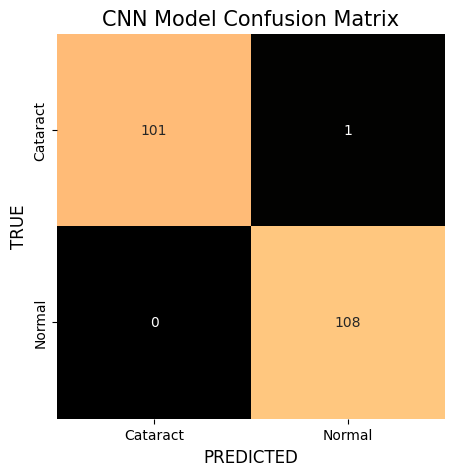

In [26]:
import seaborn as sns

Y=[]
Y_pred=[]
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred = (y_pred > 0.5)
    Y.extend(y)
    Y_pred.extend(y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, Y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='copper', cbar=False,
            xticklabels=['Cataract', 'Normal'], yticklabels=['Cataract', 'Normal'])
plt.xlabel('PREDICTED', fontsize=12)
plt.ylabel('TRUE', fontsize=12)
plt.title('CNN Model Confusion Matrix', fontsize=15)
plt.show()